## Stacked Attention Residual Seq2Seq

* Task: toy "translation" task --- translating a list of letters (from A to H) to the next-letter-list (e.g. ['A', 'B', 'C'] translates as ['B', 'C', 'D'].
* Type: Bahdanau et al. (2015); Prakash et al. (2016). Bahdanau/15 attention, . Clear-to-the-boot step-by-step demo.
* PyTorch Version: 0.3.1

**NB:** the code should run _much_ faster on your machine. The printed results are done while multiple other things are running.

In [5]:
import os
import dill
import random
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from nltk.translate.bleu_score import sentence_bleu as bleu
from nltk.translate.bleu_score import SmoothingFunction

SMOOTH = SmoothingFunction()

### Data Prep

In [6]:
class Indexer:
    """Word <-> Index mapper."""

    def __init__(self, specialTokenList=None):
        self.word2index = {}
        self.index2word = {}
        self.wordSet = set()
        self.size = 0
        if specialTokenList is not None:
            assert type(specialTokenList)==list
            for token in specialTokenList:
                self.get_index(token, add=True)

    def __repr__(self):
        return "The indexer currently has %d words" % self.size

    def get_word(self, index):
        return self.index2word[index] if index<self.size else 'UNK'

    def get_index(self, word, add=True):
        if add and word not in self.wordSet:
            self.word2index[word] = self.size
            self.index2word[self.size] = word
            self.wordSet.add(word)
            self.size += 1
        return self.word2index[word] if word in self.wordSet else self.word2index['UNK']

    def contains(self, word):
        return word in self.wordSet

    def add_sentence(self, sentence, returnIndices=True):
        indices = [self.get_index(word, add=True) for word in sentence.split()]
        return (indices,len(indices)) if returnIndices else None

    def add_document(self, docPath, returnIndices=True):
        with open(docPath, 'r') as doc:
            if returnIndices:
                indicesList, lengthList = [], []
                for line in doc:
                    indices,length = self.add_sentence(line,returnIndices)
                    if length<=0: continue # handle bad sentences in .txt.
                    indicesList.append(indices)
                    lengthList.append(length)
                return indicesList, lengthList
            else:
                for line in doc:
                    self.add_sentence(line,returnIndices=False)
                return None
    
    def to_words(self, indices):
        return [self.get_word(index) for index in indices]
    
    def to_sent(self, indices):
        return ' '.join(self.to_words(indices))
    
    def to_indices(self, words):
        return [self.get_index(word) for word in words]

class DataIterator:
    """Data feeder by batch."""

    def __init__(self, indexer, pairs, lengths, maxTargetLen=10):
        """
        Args:
            indexer: an Indexer object.
            pairs: a list of pairs of token index lists.
            lengths: a list of pairs of sentence length lists.
            maxTargetLen: uniform to decoding length later (for cross entropy computing).
        """
        self.indexer = indexer
        self.pairs = pairs
        self.lengths = lengths
        self.maxTargetLen = maxTargetLen
        self.size = len(pairs)
        self.indices = range(self.size)

    def _get_padded_sentence(self, index, maxSentLen, maxTargetLen):
        """Pad a sentence pair by EOS (pad both to the largest length of respective batch).

        Args:
            index: index of a sentence & length pair in self.pairs, self.lengths.
            maxSentLen: the length of the longest source sentence.
            maxTargetLen: the length of the longest target sentence.
        Returns:
            padded source sentence (list), its length (int), 
            padded target sentence (list), its length (int).
        """
        sent1,sent2 = self.pairs[index][0], self.pairs[index][1]
        length1,length2 = self.lengths[index][0], self.lengths[index][1]
        paddedSent1 = sent1[:maxSentLen] if length1>maxSentLen else sent1+[self.indexer.get_index('EOS')]*(maxSentLen-length1)
        paddedSent2 = sent2[:maxTargetLen] if length2>maxTargetLen else sent2+[self.indexer.get_index('EOS')]*(maxTargetLen-length2)
        return paddedSent1,length1,paddedSent2,length2

    def random_batch(self, batchSize):
        """Random batching.

        Args:
            batchSize: size of a batch of sentence pairs and respective lengths.
        Returns:
            the batch of source sentence (Variable(torch.LongTensor())),
            the lengths of source sentences (numpy.array())
            and the same for target sentences and lengths.
        """
        batchIndices = np.random.choice(self.indices, size=batchSize, replace=False)
        batchSents,batchTargets,batchSentLens,batchTargetLens = [], [], [], []
        maxSentLen, _ = np.array([self.lengths[index] for index in batchIndices]).max(axis=0)
        for index in batchIndices:
            paddedSent1,length1,paddedSent2,length2 = self._get_padded_sentence(index, maxSentLen, self.maxTargetLen)
            batchSents.append(paddedSent1)
            batchTargets.append(paddedSent2)
            batchSentLens.append(length1)
            batchTargetLens.append(length2)
        batchIndices = range(batchSize) # reindex from 0 for sorting.
        batchIndices = [i for i,l in sorted(zip(batchIndices,batchSentLens),key=lambda p:p[1],reverse=True)]
        batchSents = Variable(torch.LongTensor(np.array(batchSents)[batchIndices])).transpose(0,1) # <bc,mt> -> <mt,bc>
        batchTargets = Variable(torch.LongTensor(np.array(batchTargets)[batchIndices])).transpose(0,1)
        batchSentLens = np.array(batchSentLens)[batchIndices]
        batchTargetLens = np.array(batchTargetLens)[batchIndices]
        return batchSents, batchSentLens, batchTargets, batchTargetLens
        
class DataLoader:
    
    def __init__(self, dataDir):
        self.dataDir = dataDir # str
        self.dataDict = {path.split('.')[0]:self.dataDir+path
                         for path in os.listdir(self.dataDir) if path.endswith('.txt')}
        self.filenames = set(['train_source', 'train_target',
                              'test_source', 'test_target'])
        if self._filename_mismatch():
            raise Exception("Expected filenames under the directory:\n"+str(self.filenames)+
                            '\nGot:\n'+str(self.dataDict.keys())+'\n')
    
    def _filename_mismatch(self):
        return self.filenames - set(self.dataDict.keys()) != set([])
    
class TranslationDataLoader(DataLoader):
    
    def __init__(self, dataDir):
        DataLoader.__init__(self, dataDir)
    
    def load(self, specialTokenList=None):
        indexer = Indexer(specialTokenList)
        print "... loading training data."
        trainPairs,trainLens = self._load_pairs(indexer,
                                                self.dataDict['train_source'],
                                                self.dataDict['train_target'])
        print "... loading test data."
        testPairs,testLens = self._load_pairs(indexer,
                                              self.dataDict['test_source'],
                                              self.dataDict['test_target'])
        print "Done!\n"
        return indexer,trainPairs,trainLens,testPairs,testLens

    def _load_pairs(self, indexer, sourcePath, targetPath):
        sourceSents,sourceLens = indexer.add_document(sourcePath,returnIndices=True)
        targetSents,targetLens = indexer.add_document(targetPath,returnIndices=True)
        return zip(sourceSents, targetSents), zip(sourceLens, targetLens)

class ToyDataGenerator:
    """Generate toy translation dataset: translation to the next letter.
       E.g. ['A','B','C'] -> ['B','C','D'].
    """
    
    def __init__(self, vocab, dataSize, fromLen, toLen, cutoff,
                 trainSourcePath, trainTargetPath, testSourcePath, testTargetPath):
        """
        
        Args:
            vocab: a list of vocabulary words (in strings).
            dataSize: #entries for train + test.
            fromLen, toLen: length range of generated sentences.
            cutoff: a float between 0. and 1., proportion of training data.
            train/testSource/Path: path to saved generation.
        """
        self.vocab = vocab
        self.dataSize = dataSize
        self.fromLen = fromLen
        self.toLen = toLen
        self.cutoffIndex = (int)(cutoff*dataSize)
        self.trainSourcePath = trainSourcePath
        self.trainTargetPath = trainTargetPath
        self.testSourcePath = testSourcePath
        self.testTargetPath = testTargetPath
    
    def translate_word(self, word):
        """Find the next letter.

        Args:
            word: a letter word (e.g. 'A').
        Returns:
            The next letter to word.
        """
        return self.vocab[self.vocab.index(word)+1]
    
    def translate_sent(self, sent):
        """Find the next-letter translation of a sentence.

        Args:
            sent: a list of letter words.
        Returns:
            The next letters.
        """
        return [self.translate_word(word) for word in sent]
    
    def writeSentToFile(self, path, sent, mode):
        """Write one sentence to a file (given path).
        
        Args:
            path: path to file.
            sent: a single-string sentence.
            mode: either 'a' (append) or 'w' (write).
        """
        with open(path, mode) as f:
            f.write(sent)
            f.write('\n')
    
    def writeDataSet(self, sourcePath, targetPath, size):
        """Write train/test dataset to given source/target path (given size).
        
        Args:
            SourcePath, targetPath: paths to files.
            size: #entries.
        """
        for i in range(size):
            randInput,randTarget = self.generate_pair()
            self.writeSentToFile(sourcePath, ' '.join(randInput), mode='a' if os.path.exists(sourcePath) else 'w')
            self.writeSentToFile(targetPath, ' '.join(randTarget), mode='a' if os.path.exists(targetPath) else 'w')            
    
    def generate_pair(self):
        """Randomly generate a pair of sentences (arg1 translates to arg2).

        Returns:
            randInput: a list of letter words.
            randTarget: a list of translation letter words of randInput.
        """        
        randInput = list(np.random.choice(self.vocab[:-1], size=random.randint(self.fromLen,self.toLen)))
        randTarget = self.translate_sent(randInput)
        return randInput, randTarget+[str('EOS')]
    
    def generate_data(self):
        """Randomly generate a set of pairs of sentences (arg1 translates to arg2).

        Returns:
            pairs: a pair of lists of torch Variables (torch.LongTensor).
            lengths: lengths of the corresponding lists in pairs.
        """
        print '... generating training data'
        self.writeDataSet(self.trainSourcePath, self.trainTargetPath, self.cutoffIndex)
        print '... generating test data'
        self.writeDataSet(self.testSourcePath, self.testTargetPath, self.dataSize-self.cutoffIndex)
        print 'DONE!\n'

In [7]:
if not os.path.isdir('toy'):
    os.makedirs('toy') 
tg = ToyDataGenerator(vocab=[chr(i) for i in range(65,74)],
                      dataSize=5000,
                      fromLen=10, toLen=15,
                      cutoff=0.8,
                      trainSourcePath='toy/train_source.txt',
                      trainTargetPath='toy/train_target.txt',
                      testSourcePath='toy/test_source.txt',
                      testTargetPath='toy/test_target.txt')
tg.generate_data()

... generating training data
... generating test data
DONE!



In [19]:
trans = TranslationDataLoader('toy/')
indexer,trainPairs,trainLens,testPairs,testLens = trans.load(specialTokenList=['EOS','SOS','PAD','UNK'])

... loading training data.
... loading test data.
Done!



In [20]:
trainPairs[0][0], trainPairs[0][1]

([4, 5, 6, 5, 7, 8, 4, 6, 9, 4], [10, 4, 12, 4, 9, 5, 10, 12, 11, 10, 0])

In [21]:
print indexer.to_sent(trainPairs[0][0]), '|', indexer.to_sent(trainPairs[0][1])
print indexer.to_sent(testPairs[0][0]), '|', indexer.to_sent(testPairs[0][1])

F E H E A D F H B F | G F I F B E G I C G EOS
G F F A A D A G A H A D G B | H G G B B E B H B I B E H C EOS


### Model

In [157]:
class EncoderRNN(nn.Module):
    """Simple GRU encoder."""
    
    def __init__(self, inputSize, hiddenSize, nLayers=2, dropout=0.1):
        """
        
        Args:
            inputSize: vocabulary size.
            hiddenSize: size of RNN hidden state.
            nLayers: number of stacked layers.
            dropout: dropout rate.
        """
        # inputSize: vocabulary size.
        # hiddenSize: size for both embedding and GRU hidden.
        super(EncoderRNN, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.nLayers = nLayers
        self.embedding = nn.Embedding(inputSize, hiddenSize)
        self.dropoutLayer = nn.Dropout(p=dropout)
        self.gru = nn.GRU(hiddenSize, hiddenSize, nLayers, dropout=dropout)
    
    def forward(self, inputs, inputsLen, hidden=None):
        """
        
        Args:
            inputs: Variable(torch.LongTensor()) of the shape <max-time,batch-size>.
            inputsLen: a list of input lengths with the shape <batch-size,>.
            hidden: input hidden state (initialized as None).
        """
        # inputs: <mt,bc>
        # inputsLen: <bc,> (a list).
        # hidden: <n_layer*n_direction,bc,h>
        embedded = self.embedding(inputs) # <mt,bc,h>
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, inputsLen)
            # 'packed' has a 'data' and a 'batch_sizes' field.
            #   'data' is a <sum(len),h> matrix (len is real lengths, not padded).
            #   'batch_sizes' has the number of non-zero batches at each time-step.
            # e.g. for this 'inputs'
            #    2     1     3     0     2
            #    6     8     1     6     2
            #    0     7     0     8     8
            #    6     4     2     1     1
            #    1     8     1     1     1
            #    6     1     1     1     1
            #    0     1     1     1     1
            #    1     1     1     1     1
            #    1     1     1     1     1
            #    1     1     1     1     1  
            # 'data' = 22 = 7+5+4+3+3 (1's are pads corresponding to 'EOS').
            # 'batch_sizes' = [5, 5, 5, 3, 2, 1, 1].
        outputs,hidden = self.gru(packed, hidden)#, dropout=dropout)
            # outputs: same format as 'packed'.
            # hidden: <n_layer*n_direction,bc,h>
        outputs, outputsLen = torch.nn.utils.rnn.pad_packed_sequence(outputs)
            # outputs: <mt,bc,h>
            # outputsLen: same as the 'batch_sizes' field of 'packed'. 
        outputs = self.dropoutLayer(outputs)
        return outputs, hidden
    

class AttentionDecoderRNN(nn.Module):
    """Simple GRU decoder (Bahdanau attention)."""
    
    def __init__(self, hiddenSize, outputSize, nLayers=2, dropout=0.1, residual=True):
        """
        
        Args:
            hiddenSize: GRU hidden state size.
            outputSize: vocabulary size.
            nLayers: number of stacked layers.
            dropout: dropout rate.
            residual: boolean, whether establish residual link or not.
        """
        super(AttentionDecoderRNN, self).__init__()
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.nLayers = nLayers
        self.residual = residual
        self.embedding = nn.Embedding(outputSize, hiddenSize)
        self.dropoutLayer = nn.Dropout(p=dropout)
        self.gru = nn.GRU(2*hiddenSize, hiddenSize, nLayers) 
        self.out = nn.Linear(2*hiddenSize, outputSize)
            # inputSize doubles because concatted context of same hiddenSize.
        self.linear = nn.Linear(hiddenSize, hiddenSize)

    def forward(self, inputs, hidden, context, encoderOutput):
        """
        
        Args:
            inputs: inputs to decoder, of the shape <batch-size,> (1 time-step).
            hidden: <n_layers*n_directions,batch-size,hidden-size>.
            context: context vector made using attention, <batch-size,hidden-size>.
            encoderOutput: <max-time,batch-size,hidden-size>.
            NB: all are Variable(torch.LongTensor()).
        Returns:
            output: <batch-size,vocab-size>.
            hidden: <n_layers*n_directions,batch-size,hidden-size>.
            context: <batch-size,hidden-size>.
            attentionWeights: <batch-size,max-time>.
        """
            # inputs: <bc,>
            # hidden: <n_layer*n_direction,bc,h>
            # context: <bc,h>
            # encoderOutput: <mt,bc,h>  
        batchSize = inputs.size(0)
        encoderOutputLen = encoderOutput.size(0)
        embedded = self.embedding(inputs).view(1,batchSize,self.hiddenSize) # <mt=1,bc,h>
        inputs = torch.cat((embedded,context.unsqueeze(0)),2)
            # unsqueeze: <bc,h> -> <mt=1,bc,h>
            # concat: <mt,bc,h> & <mt,bc,h> @2 -> <mt,bc,2h>
        output, hidden = self.gru(inputs, hidden)#, dropout=dropout)
            # IN: <mt=1,bc,2h>, <n_layer*n_direction,bc,h>
            # OUT: <mt=1,bc,h>, <n_layer*n_direction,bc,h>
        output = self.dropoutLayer(output)
        hidden = hidden + embedded if self.residual else hidden
        attentionWeights = Variable(torch.zeros(batchSize,encoderOutputLen)).cuda()
        for b in range(batchSize):
            rawAttentionWeight = torch.mm(self.linear(encoderOutput[:,b,:]), 
                                          hidden[:,b,:][-1].unsqueeze(1)).squeeze()
                # op1. linear transformation on encoderOutput (dot energy).
                # op2. select <mt,h> and <1,h> slices (from <mt,bc,h> and <1,bc,h>).
                # op3. sel hidden last dim <h,> and expand -> <mt,h> & <h,1> now.
                # op4. matmul -> <mt,1>.
                # op5. squeeze -> <mt,>
            attentionWeights[b] = F.softmax(rawAttentionWeight, dim=-1)
                # normalize to get a distribution.
            # result: <bc,mt> attention matrix, normalized along mt.
        multiDiag = Variable(torch.eye(batchSize).expand(self.hiddenSize,batchSize,batchSize),
                             requires_grad=False).cuda()
            # op1. eye -> <bc,bc> diagonal matrix mask.
            # op2. expand -> <h,bc,bc>, same shape as attended encoderOutput.
            # op3. Variable/grad=false: same type as attended encoderOutput.
        context = (torch.matmul(attentionWeights, encoderOutput.permute(2,0,1)) * multiDiag).sum(dim=2).transpose(0,1)
            # op1. masking -> <h,bc,bc>, with the last 2 dims only have non-zero diag elems.
            # op2. compress 1 bc dimension (useless, because its diag).
            # op3. <h,bc> -> <bc,h>, keep input shape.
        output = output.squeeze(0)
            # output squeeze: <mt=1,bc=1,h> -> <bc,h>, to concat with context
        output = F.log_softmax(F.tanh(self.out(torch.cat((output,context),1))),dim=-1)
            # concat: <bc,h> & <bc,h> @1 -> <bc,2h>
            # linear->tahn/out: <bc,2h> * <2h,vocab> -> <bc,vocab>
            # softmax: along dim=-1, i.e. vocab.  
        return output, hidden, context, attentionWeights
            # full output for visualization:
            #   output: <bc,vocab>
            #   hidden: <n_layer*n_direction,bc,h>
            #   context: <bc,h>
            #   attentionWeights: <bc,mt> 

class Seq2Seq:
    """Encoder-Decoder model with Bahdanau attention, stacking and residual links."""
    
    def __init__(self, indexer, trainPairs, trainLens, testPairs, testLens, 
                 batchSize=5, hiddenSize=10,
                 nLayers=2, dropout=0.1, residual=True, 
                 lr=1e-4, lrDecay=0.95, lrDecayFreq=100,
                 l2Reg=0.5,
                 enforcingRatio=0.5, clip=5.0,
                 maxDecodingLen=10,
                 resultSavePath='toy/results.txt'):
        """
        
        Args:
            indexer: an Indexer object.
            trainPairs, testPairs: each is a list of pairs of word index list.
            trainLens, testLens: each is a list of pairs of length of word index list.
            batchSize: int. (default=5)
            hiddenSize: int. (default=10)
            nLayers: number of GRU stacking layers. (default=2)
            dropout: dropout rate. (default=0.1)
            residual: boolean, whether to establish residual links. (default=True)
            lr: learning rate, float. (default=1e-4 with Adam)
            lrDecay: rate at which lr drops per m batches.
            lrDecayFreq: the number of batches per lr decay.
            l2Reg: ridge regression.
            enforcingRatio: the percentage of teacher-enforced training. (default=0.5)
            clip: gradient clip cap, float. (default=5.0)
            maxDecodingLen: max #tokens generated by decoder before stopping.
            resultSavePath: (input,prediction,target) sentence triples file path.
        """
        self.indexer = indexer
        self.trainIter = DataIterator(indexer, trainPairs, trainLens, maxTargetLen=maxDecodingLen)
        self.testIter = DataIterator(indexer, testPairs, testLens, maxTargetLen=maxDecodingLen)
        self.batchSize = batchSize
        self.hiddenSize = hiddenSize
        self.nLayers = nLayers
        self.dropout = dropout
        self.residual = residual
        self.lr = lr
        self.lrDecay = lrDecay
        self.lrDecayFreq = lrDecayFreq
        self.l2Reg = l2Reg
        self.enforcingRatio = enforcingRatio
        self.clip = clip
        self.maxDecodingLen = maxDecodingLen
        self.resultSavePath = resultSavePath
        self._build_model()
    
    def _build_model(self):
        """Specify computational graph."""
        self.encoder = EncoderRNN(self.indexer.size, self.hiddenSize, 
                                  nLayers=self.nLayers, dropout=self.dropout).cuda()
        self.decoder = AttentionDecoderRNN(self.hiddenSize, self.indexer.size,
                                           nLayers=self.nLayers, dropout=self.dropout, residual=self.residual).cuda()
        self.encoderOptim = optim.Adam(self.encoder.parameters(), self.lr, weight_decay=self.l2Reg)
        self.decoderOptim = optim.Adam(self.decoder.parameters(), self.lr, weight_decay=self.l2Reg)
        self.criterion = nn.NLLLoss()
    
    def _model_config(self):
        return 'Vocab Size = ' + str(self.indexer.size) + '\n' + \
               'Train/Test Size = ' + str(self.trainIter.size)+'/'+str(self.testIter.size) + '\n' + \
               'batchSize = ' + str(self.batchSize) + '; hiddenSize = ' + str(self.hiddenSize) + '\n' + \
               'nLayers = ' + str(self.nLayers) + '; dropout = ' + str(self.dropout) + '\n' + \
               'residual = ' + str(self.residual) + '; learning rate = ' + str(self.lr) + '\n' + \
               'learning rate decay = ' + str(self.lrDecay) + ' per ' + str(self.lrDecayFreq) + ' batches/steps\n' + \
               'regularization (l2) = ' + str(self.l2Reg) + '\n' + \
               'teacher enforce ratio = ' + str(self.enforcingRatio) + '; clip = ' + str(self.clip) + '\nn'
    
    def _lr_decay(self, encOptim, decOptim):
        self.lr *= self.lrDecay
        for paramGroup in encOptim.param_groups:
            paramGroup['lr'] = self.lr
        for paramGroup in decOptim.param_groups:
            paramGroup['lr'] = self.lr
        return encOptim, decOptim
   
    def _train_step(self):
        """One step of training."""
        inputs, inputsLen, targets, targetsLen = self.trainIter.random_batch(self.batchSize)
        inputs, targets = inputs.cuda(), targets.cuda()
        self.encoderOptim.zero_grad()
        self.decoderOptim.zero_grad()
        loss = 0
        # Run encoder
        encoderHidden = None
        encoderOutput, encoderHidden = self.encoder(inputs, inputsLen, encoderHidden)    
        # Run decoder
        decoderInput = Variable(torch.LongTensor([self.indexer.get_index('SOS')]*self.batchSize)).cuda()
        decoderContext = Variable(torch.zeros(self.batchSize,self.decoder.hiddenSize)).cuda()
        decoderHidden = encoderHidden
        enforce = random.random() < self.enforcingRatio
        decoderOutputAll = Variable(torch.zeros(self.maxDecodingLen,self.batchSize,self.decoder.outputSize)).cuda()
            # <mt-max,bc,vocab>
        mask = torch.LongTensor([1]*self.batchSize).cuda()
            # start with 1, a cell turns 0 to mask out generation after an EOS is seen.
        for di in range(self.maxDecodingLen):
            decoderOutput,decoderHidden,decoderContext,attentionWeights = self.decoder(decoderInput,
                                                                                       decoderHidden,
                                                                                       decoderContext, 
                                                                                       encoderOutput)
            decoderOutputAll[di] = decoderOutput
            if enforce:
                decoderInput = targets[di] # <== targets is <mt,bc>
            else:
                topValues,topIndices = decoderOutput.data.topk(1) # <bc,1>
                topIndices = topIndices.squeeze()# topIndices = <bc,>
                for b in range(self.batchSize):
                    if topIndices[b] == 0: # EOS
                        mask[b] = 0
                topIndices = topIndices * mask
                decoderInput = Variable(topIndices).cuda()
        # Batch cross entropy
            # requires arg1/pred = <#entries,vocab>, arg2/target = <#entries,>
        decoderOutputAll = decoderOutputAll.view(-1, self.decoder.outputSize)
            # reshape to <mt*bc,vocab>
        targets = targets.contiguous().view(-1)
            # reshape to <mt*bc>
        loss = self.criterion(decoderOutputAll, targets)
        # Backprop
        loss.backward()
        torch.nn.utils.clip_grad_norm(self.encoder.parameters(), self.clip)
        torch.nn.utils.clip_grad_norm(self.decoder.parameters(), self.clip)
        self.encoderOptim.step()
        self.decoderOptim.step()
        return loss.data[0] / targetsLen        
    
    def train(self, nEpochs=1, epochSize=100, printEvery=5, endOfEpochPlot=True):
        """Train on loaded data upon construction.
        
        Args:
            nEpochs: number of epochs.
            epochSize: number of batches trained in an epoch.
            printEvery: frequency of results report.
        """
        globalStep = 0
        averageLoss = 0
        start = time.time()
        for e in range(nEpochs):
            epochLoss = 0
            for step in range(epochSize):
                loss = self._train_step()
                if step!=0 and step%printEvery==0:
                    print("Step %d average loss = %.4f (time: %.2f)" % (step, loss.mean(), # batch mean.
                                                                        time.time()-start))
                    start = time.time()
                epochLoss += loss.mean()
                globalStep += 1
                if globalStep%self.lrDecayFreq==0:
                    print '  [LR DECAY] from %.10f to %.10f at step %d' % (self.lr, self.lr*self.lrDecay, globalStep)
                    self.encoderOptim, self.decoderOptim = self._lr_decay(self.encoderOptim, self.decoderOptim)
            epochLoss /= epochSize
            averageLoss += epochLoss
            print("\nEpoch %d loss = %.4f\n" % (e+1,epochLoss))
            averageBleu = self.evaluate_random(size=self.batchSize, saveResults=False, printResults=True)
            
            # plot here
            
            
            
        averageLoss /= nEpochs
        print("\nGrand average loss = %.4f\n" % averageLoss) 
        
    def _clear_special_tokens(self, words):
        """Clear all the PAD, UNK, EOS to avoid inflated BLEU.
        
        Args:
            words: a list of tokens.
        Returns:
            a list of tokens which are not special tokens.
        """
        return [word for word in words if word not in set(["PAD","UNK","EOS","SOS"])]

    def evaluate_pair(self, predWords, targetWords):
        """Compute the BLEU score of a prediction given a reference.
        
        Args:
            predWords: predicted words (a list of strings).
            targetWords: reference, same type as preWords.
        Returns:
            The BLEU score (uses = nltk.translate.bleu_score.sentence_bleu).
        """
        return bleu([targetWords], 
                     predWords, smoothing_function=SMOOTH.method3)

    def _print_heatmap(self, attentionWeightsAll, inputs, predictions, targets):
        """Plot alignment heatmaps.
        
        Args:
            attentionWeightsAll: shape <bc,mt-dec=maxDecodingLen,mt-enc=inputsLen>
            inputs: <bc,mt-enc=inputsLen>
            predictions: <bc,mt-dec=maxDecodingLen>
            targets: <bc,mt-dec=targetsLen>
            NB: all types = numpy.ndarray.
        """

        print '=========== HEATMAPS =========='
        for aw,iw,pw,tw in zip(attentionWeightsAll,inputs,predictions,targets): # <mt,vocab>
            _, ax = plt.subplots()
            xticks = self.indexer.to_words(iw)
            yticks = [p+'-'+t for p,t in zip(self.indexer.to_words(pw),self.indexer.to_words(tw))]
            ax = sns.heatmap(aw, xticklabels=xticks, yticklabels=yticks)
            ax.xaxis.tick_top()
            plt.show()
        print '===============================\n\n'
    
    
    def evaluate_random(self, size, saveResults, printResults=True, endOfEpochPlot=True):
        """Randomly evaluate samples from the test set (which is loaded upon construction).
        
        Args:
            size: number of samples evaluated (as a single batch).
            printResults: print input, prediction and gold translation to console. (default=True)
        Returns:
            The average BLEU score in the batch.
        """
        self.encoder.eval()
        self.decoder.eval()
        inputs, inputsLen, targets, targetsLen = self.testIter.random_batch(size)
        inputs, targets = inputs.cuda(), targets.cuda()
        # Run encoder
        encoderHidden = None
        encoderOutput, encoderHidden = self.encoder(inputs, inputsLen, encoderHidden)
        # Run decoder
        decoderInput = Variable(torch.LongTensor([self.indexer.get_index('SOS')]*size)).cuda()
        decoderContext = Variable(torch.zeros(size,self.decoder.hiddenSize)).cuda()
        decoderHidden = encoderHidden
        predictions = []
        attentionWeightsAll = []
        for di in range(self.maxDecodingLen):
            decoderOutput,decoderHidden,decoderContext,attentionWeights = self.decoder(decoderInput,
                                                                                       decoderHidden,
                                                                                       decoderContext, 
                                                                                       encoderOutput)
            attentionWeightsAll.append(attentionWeights)
            topValues,topIndices = decoderOutput.data.topk(1) # <bc,1>
            decoderInput = Variable(topIndices.squeeze()).cuda() # <bc,1> -> <bc,>
            predictions.append(topIndices.view(-1).cpu().numpy())
        attentionWeightsAll = np.array([aw.data.cpu().numpy() for aw in attentionWeightsAll])
        attentionWeightsAll = attentionWeightsAll.swapaxes(0,1) # <mt-dec,bc,mt-enc> -> <bc,mt-dec,mt-enc> 
        inputs = inputs.data.cpu().numpy().transpose()
        predictions = np.array(predictions).transpose() # <mt,bc> -> <bc,mt>
        targets = targets.data.cpu().numpy().transpose()
        
        if endOfEpochPlot:
            self._print_heatmap(attentionWeightsAll, inputs, predictions, targets)
        
        bleuList = []
        results = []
        for i,(input,pred,target) in enumerate(zip(inputs,predictions,targets)):
            inputWords = self._clear_special_tokens(self.indexer.to_words(input))
            predWords = self._clear_special_tokens(self.indexer.to_words(pred))
            targetWords = self._clear_special_tokens(self.indexer.to_words(target))
            bleuCurr = self.evaluate_pair(predWords, targetWords)
            bleuList.append(bleuCurr)
            inputSent = ' '.join(inputWords)
            predSent = ' '.join(predWords)
            targetSent = ' '.join(targetWords)
            results.append([inputSent, predSent, targetSent])
            if printResults:
                print("Example %d" % (i+1))
                print("INPUT >> %s" % inputSent)
                print("PRED >> %s" % predSent)
                print("TRUE >> %s" % targetSent)
                print("[BLEU] %.2f\n" % bleuCurr)
        averageBleu = np.mean(bleuList)
        if saveResults:
            return averageBleu, results
        return averageBleu

    def evaluate(self, nBatches=10, saveResults=True):
        """Randomly evaluate a given number of batches.
        
        Args:
            nBatches: the number of random batches to be evaluated.
        """
        averageBleuList = []
        for i in range(nBatches):
            if saveResults:
                averageBleu, results = self.evaluate_random(self.batchSize, saveResults, printResults=False,
                                                            endOfEpochPlot=False)
                averageBleuList.append(averageBleu)
                with open(self.resultSavePath, 'a') as f:
                    if i==0:
                        f.write(self._model_config())
                        f.write('=================================\n')
                    for input,pred,target in results:
                        f.write('INPUT  >> ' + input + '\n')
                        f.write('PRED   >> ' + pred + '\n')
                        f.write('TARGET >> ' + target + '\n\n')
            else:
                averageBleuList.append(self.evaluate_random(self.batchSize, saveResults, 
                                                            printResults=False, endOfEpochPlot=False))
        message = "Average BLEU score over %d examples is %.4f" % (self.batchSize*nBatches, 
                                                                   np.mean(averageBleuList))
        with open(self.resultSavePath, 'a') as f:
            f.write('=================================\n')
            f.write(message)
        print message
            
    def evaluate_given(self, sent, maxLen=20):
        """Evaluate a give sentence.
        
        Args:
            sentence: a single string. OOVs are treated as UNKs.
            maxLen: the max number of decoding steps.
        """
        sent = sent.split()
        sentCode = [self.indexer.get_index(word,add=False) for word in sent]
        if any(i==-1 for i in sentCode):
            raise Exception("This sentence contains out of vocabulary words!")
        input = Variable(torch.LongTensor(sentCode)).cuda().view(-1,1)
        inputLen = np.array([len(sentCode)])
        # Run encoder
        encoderHidden = None
        encoderOutput, encoderHidden = self.encoder(input, inputLen, encoderHidden)
        # Run decoder
        decoderInput = Variable(torch.LongTensor([self.indexer.get_index('SOS')]*1)).cuda()
        decoderContext = Variable(torch.zeros(1,self.decoder.hiddenSize)).cuda()
        decoderHidden = encoderHidden
        pred = []
        for di in range(maxLen):
            decoderOutput,decoderHidden,decoderContext,attentionWeights = self.decoder(decoderInput,
                                                                                       decoderHidden,
                                                                                       decoderContext, 
                                                                                       encoderOutput)
            topValues,topIndices = decoderOutput.data.topk(1) # <bc,1>
            decoderInput = Variable(topIndices.squeeze()).cuda() # <bc,1> -> <bc,>
            predIndex = topIndices.view(-1).cpu().numpy()[0]
            if predIndex == self.indexer.get_index('EOS'):
                break
            pred.append(predIndex)
        print("INPUT >> %s" % ' '.join(sent))
        print("PRED >> %s\n" % ' '.join(self.indexer.to_words(pred))) 
        

Step 100 average loss = 0.1565 (time: 10.63)
Step 200 average loss = 0.1302 (time: 10.50)
Step 300 average loss = 0.1247 (time: 10.43)
Step 400 average loss = 0.1424 (time: 10.60)

Epoch 1 loss = 0.1316

=========== HEATMAPS ==========


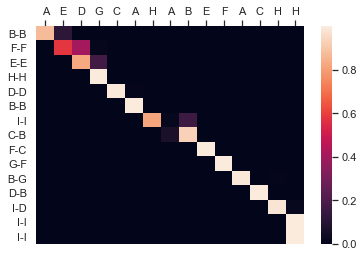

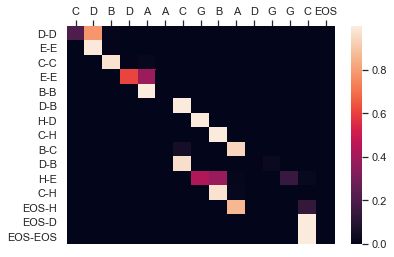

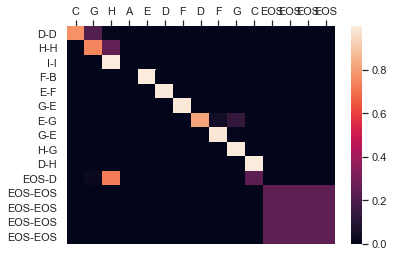

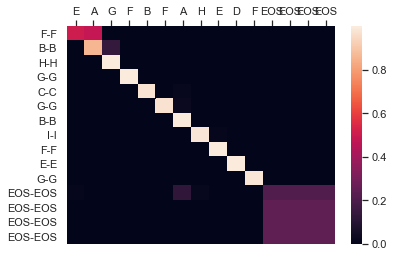

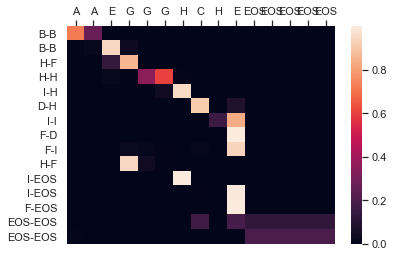



Example 1
INPUT >> A E D G C A H A B E F A C H H
PRED >> B F E H D B I C F G B D I I I
TRUE >> B F E H D B I B C F G B D I I
[BLEU] 0.80

Example 2
INPUT >> C D B D A A C G B A D G G C
PRED >> D E C E B D H C B D H C
TRUE >> D E C E B B D H C B E H H D
[BLEU] 0.55

Example 3
INPUT >> C G H A E D F D F G C
PRED >> D H I F E G E G H D
TRUE >> D H I B F E G E G H D
[BLEU] 0.71

Example 4
INPUT >> E A G F B F A H E D F
PRED >> F B H G C G B I F E G
TRUE >> F B H G C G B I F E G
[BLEU] 1.00

Example 5
INPUT >> A A E G G G H C H E
PRED >> B B H H I D I F F H I I F
TRUE >> B B F H H H I D I F
[BLEU] 0.47

Step 100 average loss = 0.1268 (time: 21.41)
Step 200 average loss = 0.0947 (time: 10.44)
Step 300 average loss = 0.0843 (time: 10.39)
Step 400 average loss = 0.0854 (time: 10.54)

Epoch 2 loss = 0.0885

=========== HEATMAPS ==========


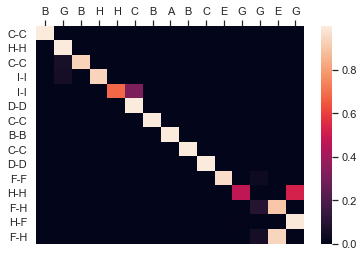

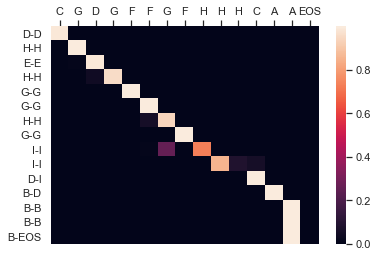

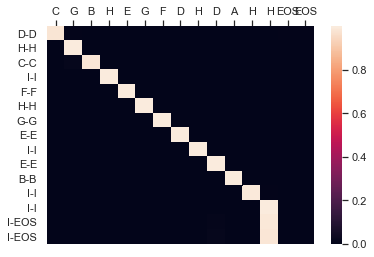

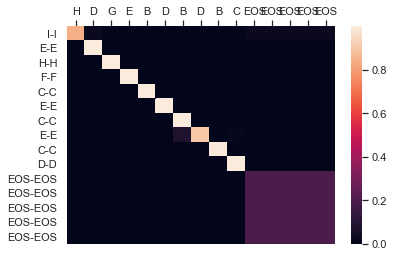

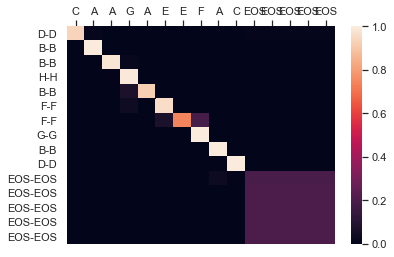



Example 1
INPUT >> B G B H H C B A B C E G G E G
PRED >> C H C I I D C B C D F H F H F
TRUE >> C H C I I D C B C D F H H F H
[BLEU] 0.86

Example 2
INPUT >> C G D G F F G F H H H C A A
PRED >> D H E H G G H G I I D B B B B
TRUE >> D H E H G G H G I I I D B B
[BLEU] 0.83

Example 3
INPUT >> C G B H E G F D H D A H H
PRED >> D H C I F H G E I E B I I I I
TRUE >> D H C I F H G E I E B I I
[BLEU] 0.85

Example 4
INPUT >> H D G E B D B D B C
PRED >> I E H F C E C E C D
TRUE >> I E H F C E C E C D
[BLEU] 1.00

Example 5
INPUT >> C A A G A E E F A C
PRED >> D B B H B F F G B D
TRUE >> D B B H B F F G B D
[BLEU] 1.00

Step 100 average loss = 0.0981 (time: 21.65)
Step 200 average loss = 0.0910 (time: 10.14)
Step 300 average loss = 0.0772 (time: 10.41)
Step 400 average loss = 0.0793 (time: 10.57)

Epoch 3 loss = 0.0807

=========== HEATMAPS ==========


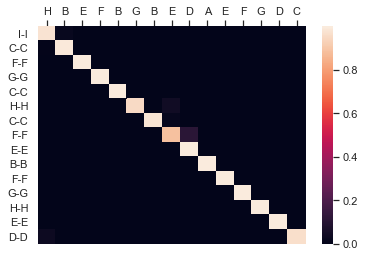

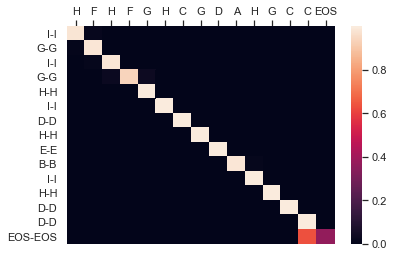

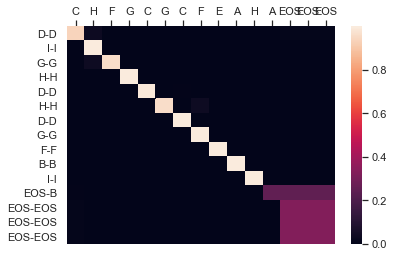

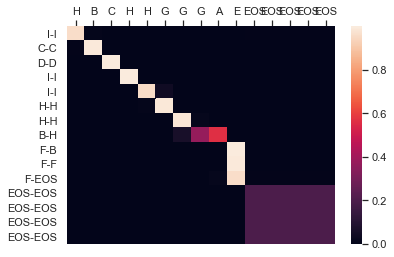

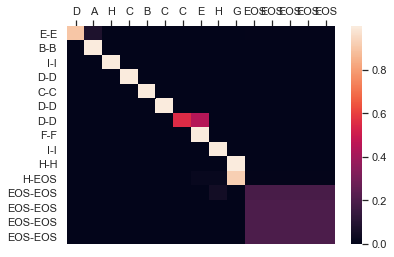



Example 1
INPUT >> H B E F B G B E D A E F G D C
PRED >> I C F G C H C F E B F G H E D
TRUE >> I C F G C H C F E B F G H E D
[BLEU] 1.00

Example 2
INPUT >> H F H F G H C G D A H G C C
PRED >> I G I G H I D H E B I H D D
TRUE >> I G I G H I D H E B I H D D
[BLEU] 1.00

Example 3
INPUT >> C H F G C G C F E A H A
PRED >> D I G H D H D G F B I
TRUE >> D I G H D H D G F B I B
[BLEU] 0.91

Example 4
INPUT >> H B C H H G G G A E
PRED >> I C D I I H H B F F F
TRUE >> I C D I I H H H B F
[BLEU] 0.75

Example 5
INPUT >> D A H C B C C E H G
PRED >> E B I D C D D F I H H
TRUE >> E B I D C D D F I H
[BLEU] 0.89

Step 100 average loss = 0.0740 (time: 21.41)
Step 200 average loss = 0.0754 (time: 10.45)
Step 300 average loss = 0.0757 (time: 10.31)
Step 400 average loss = 0.0737 (time: 10.48)

Epoch 4 loss = 0.0776

=========== HEATMAPS ==========


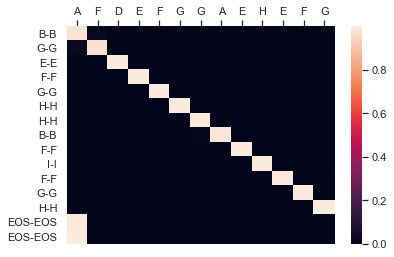

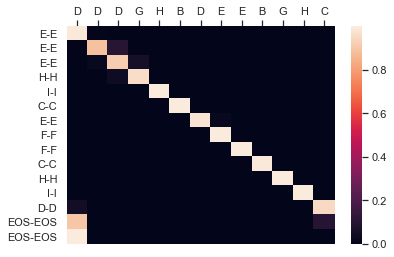

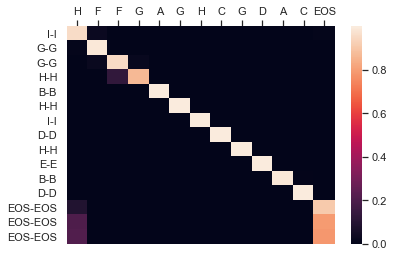

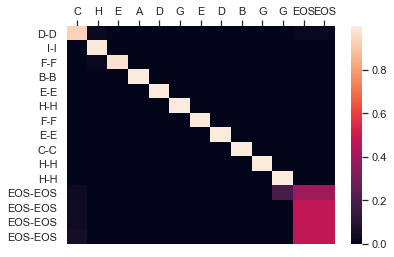

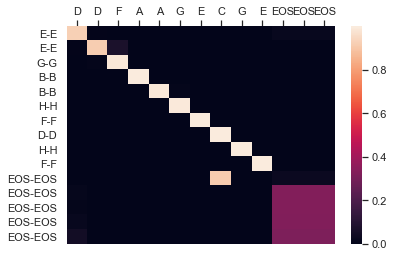



Example 1
INPUT >> A F D E F G G A E H E F G
PRED >> B G E F G H H B F I F G H
TRUE >> B G E F G H H B F I F G H
[BLEU] 1.00

Example 2
INPUT >> D D D G H B D E E B G H C
PRED >> E E E H I C E F F C H I D
TRUE >> E E E H I C E F F C H I D
[BLEU] 1.00

Example 3
INPUT >> H F F G A G H C G D A C
PRED >> I G G H B H I D H E B D
TRUE >> I G G H B H I D H E B D
[BLEU] 1.00

Example 4
INPUT >> C H E A D G E D B G G
PRED >> D I F B E H F E C H H
TRUE >> D I F B E H F E C H H
[BLEU] 1.00

Example 5
INPUT >> D D F A A G E C G E
PRED >> E E G B B H F D H F
TRUE >> E E G B B H F D H F
[BLEU] 1.00

Step 100 average loss = 0.0747 (time: 21.38)
Step 200 average loss = 0.0802 (time: 10.19)
Step 300 average loss = 0.0729 (time: 10.55)
Step 400 average loss = 0.0714 (time: 10.44)

Epoch 5 loss = 0.0760

=========== HEATMAPS ==========


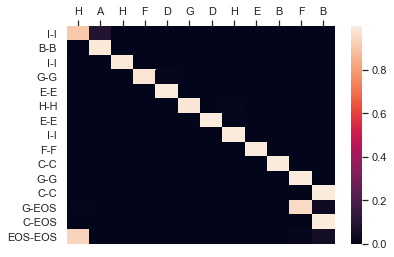

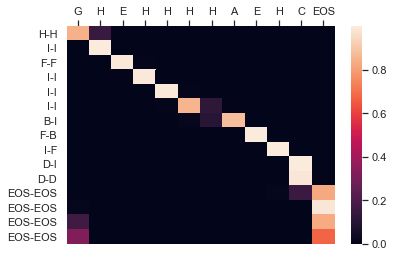

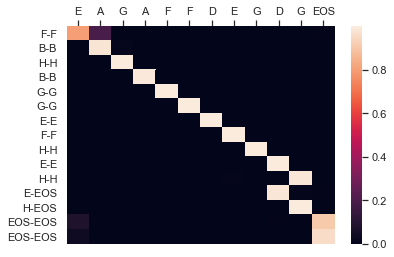

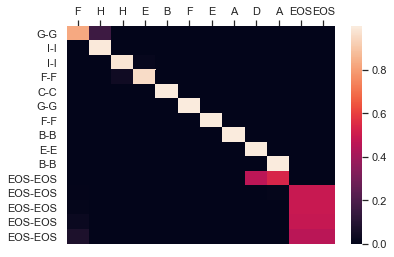

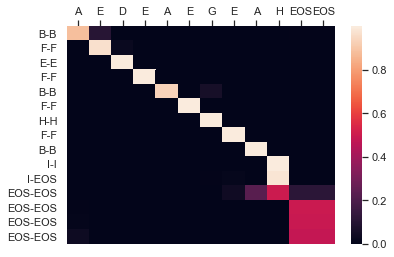



Example 1
INPUT >> H A H F D G D H E B F B
PRED >> I B I G E H E I F C G C G C
TRUE >> I B I G E H E I F C G C
[BLEU] 0.84

Example 2
INPUT >> G H E H H H H A E H C
PRED >> H I F I I I B F I D D
TRUE >> H I F I I I I B F I D
[BLEU] 0.89

Example 3
INPUT >> E A G A F F D E G D G
PRED >> F B H B G G E F H E H E H
TRUE >> F B H B G G E F H E H
[BLEU] 0.82

Example 4
INPUT >> F H H E B F E A D A
PRED >> G I I F C G F B E B
TRUE >> G I I F C G F B E B
[BLEU] 1.00

Example 5
INPUT >> A E D E A E G E A H
PRED >> B F E F B F H F B I I
TRUE >> B F E F B F H F B I
[BLEU] 0.89


Grand average loss = 0.0909

=========== HEATMAPS ==========


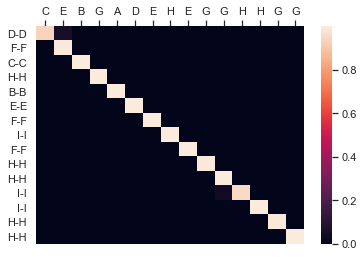

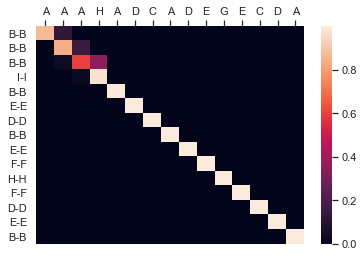

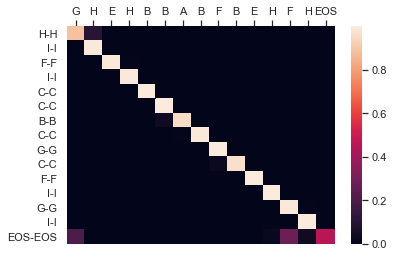

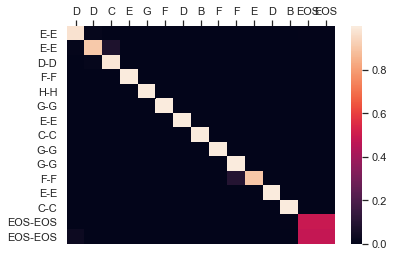

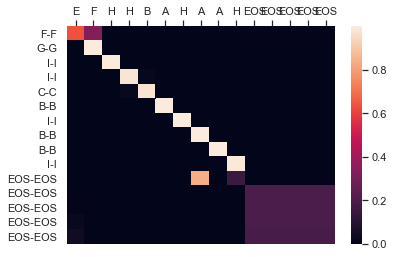



=========== HEATMAPS ==========


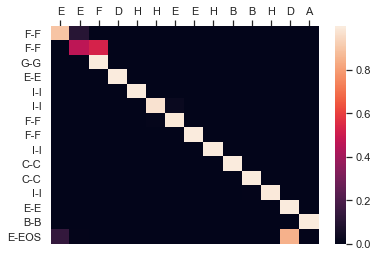

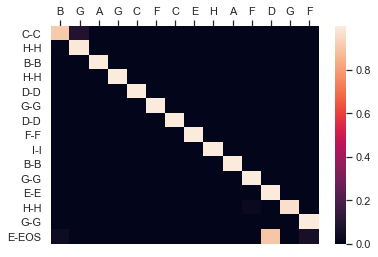

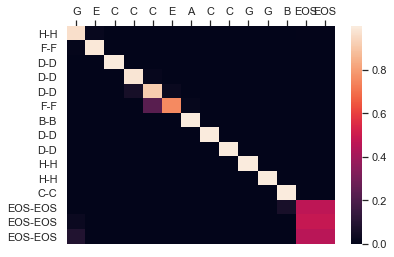

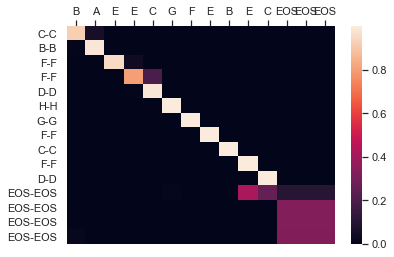

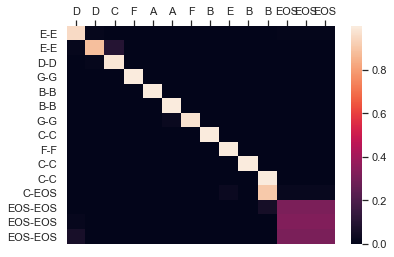



=========== HEATMAPS ==========


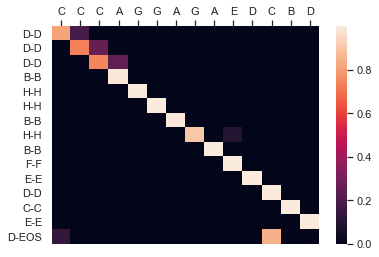

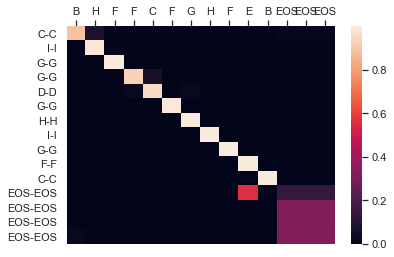

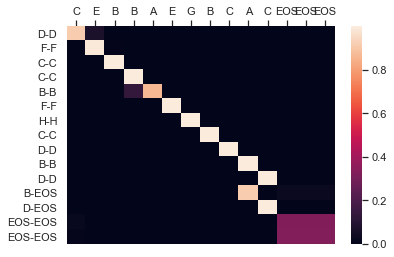

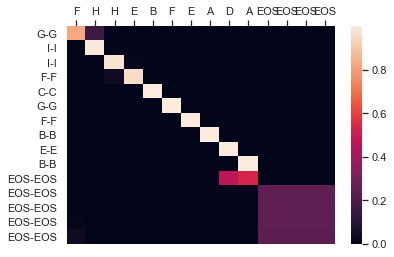

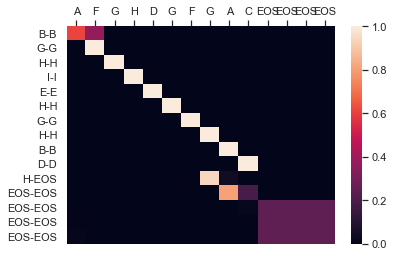



=========== HEATMAPS ==========


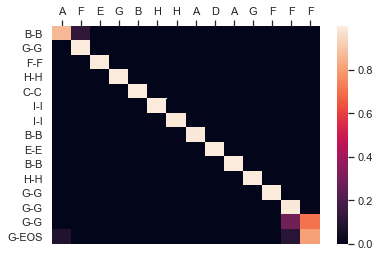

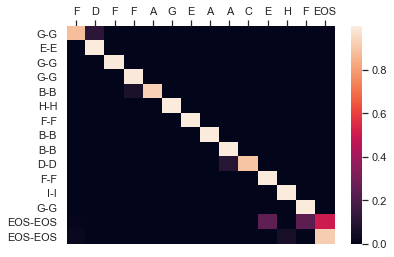

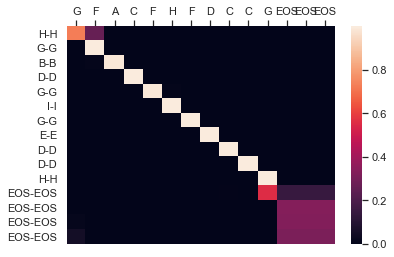

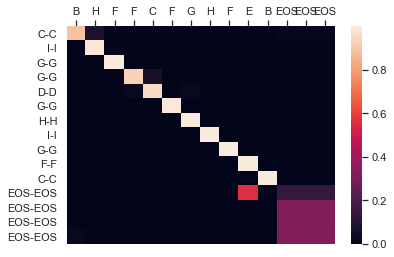

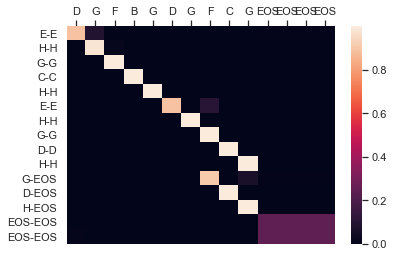



=========== HEATMAPS ==========


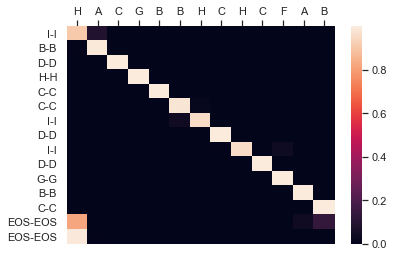

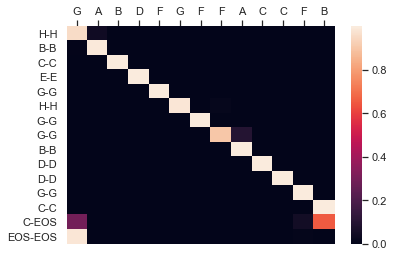

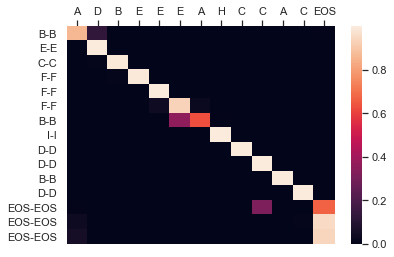

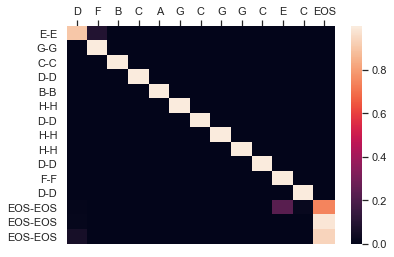

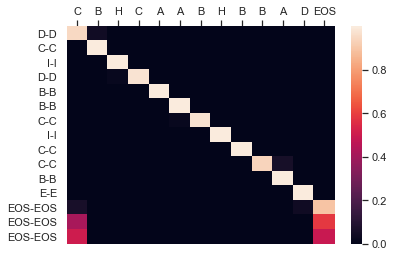



=========== HEATMAPS ==========


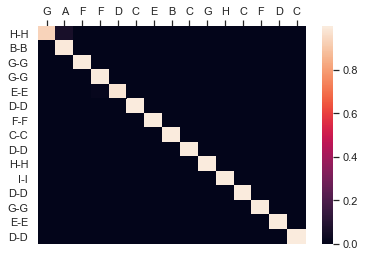

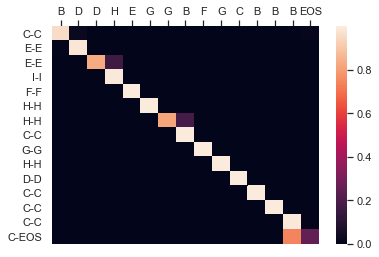

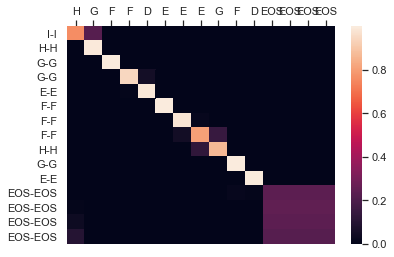

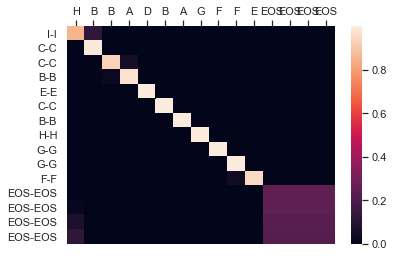

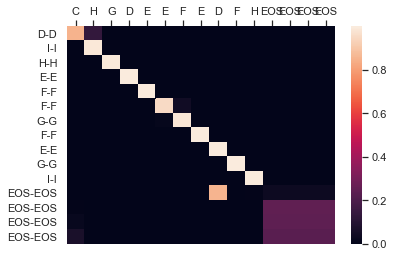



=========== HEATMAPS ==========


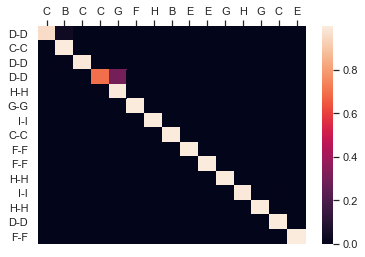

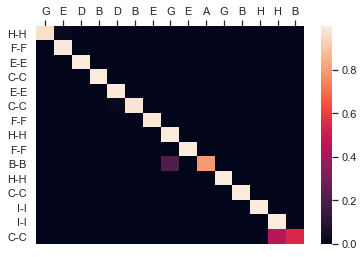

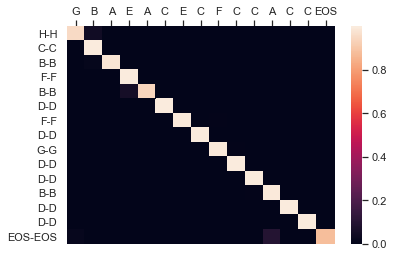

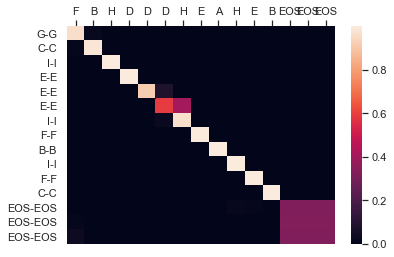

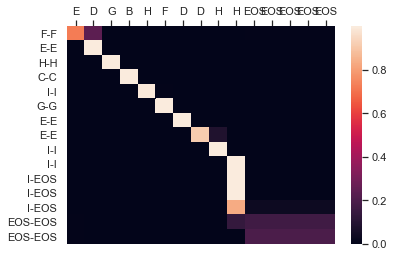



=========== HEATMAPS ==========


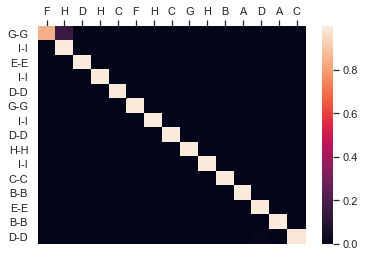

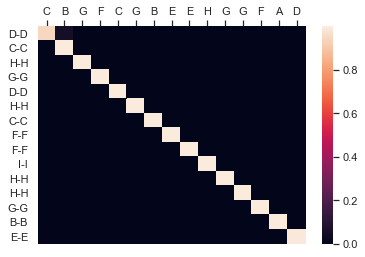

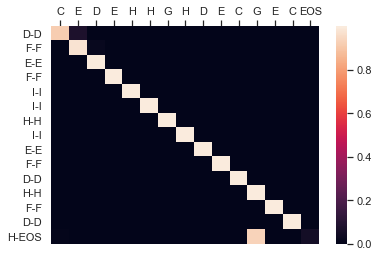

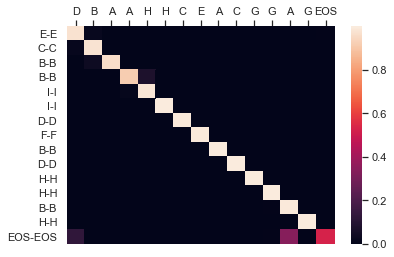

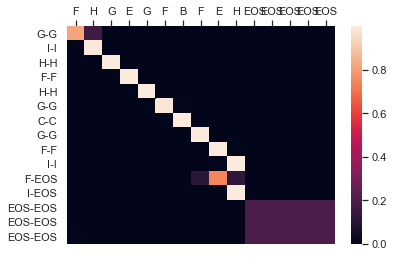



=========== HEATMAPS ==========


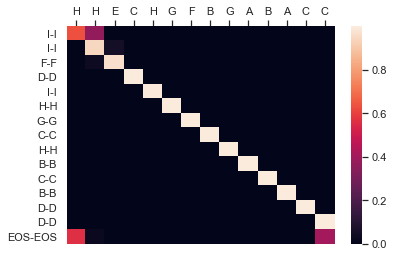

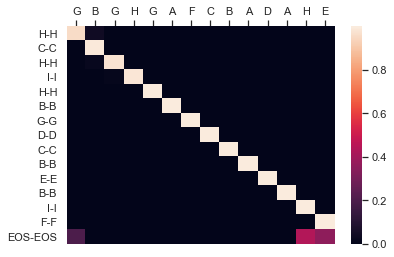

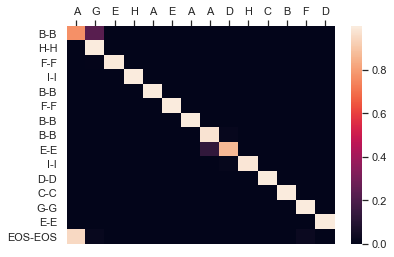

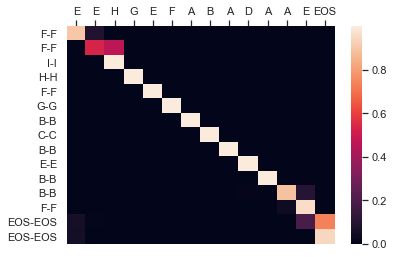

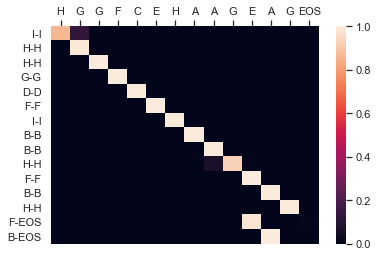



=========== HEATMAPS ==========


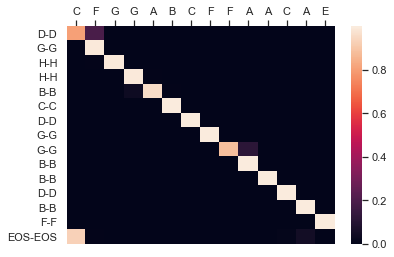

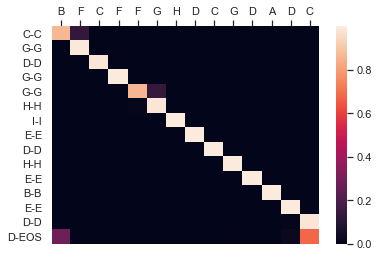

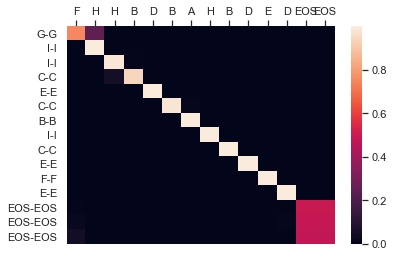

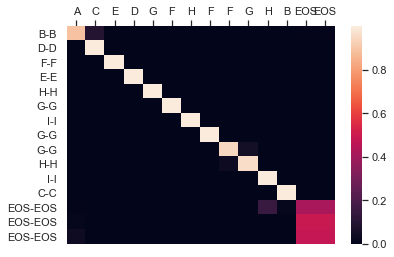

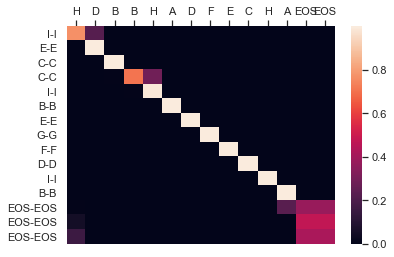



Average BLEU score over 50 examples is 0.9630
CPU times: user 3min 8s, sys: 1min 44s, total: 4min 52s
Wall time: 4min 31s


In [158]:
%%time

s2s = Seq2Seq(indexer, trainPairs, trainLens, testPairs, testLens, 
              batchSize=5, hiddenSize=100,
              nLayers=2, dropout=0.3, residual=True, 
              lr=1e-3, lrDecay=0.95, lrDecayFreq=1000000, # i.e. don't do decay.
              l2Reg=0.001,
              enforcingRatio=0.8, clip=20.0,
              maxDecodingLen=15,
              resultSavePath='toy/results.txt')
s2s.train(nEpochs=5, epochSize=500, printEvery=100, endOfEpochPlot=True)
s2s.evaluate(nBatches=10, saveResults=True)
torch.save(s2s, 'toy/seq2seq.ckpt')

#### APPENDIX. SCRIPTIFY

In [ ]:
if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_path', help="Path to formatted input to Seq2Seq. See Seq2Seq documentation.",
                        type=str,
                        default='toy/toy_formatted.p')
    parser.add_argument('--model_save_path', help="Path to saved Seq2Seq model.",
                        type=str,
                        default='toy/seq2seq.ckpt')
    parser.add_argument('--result_save_path', help="Path to save results.",
                        type=str, default='toy/results.txt')
    parser.add_argument('--clear_prev_result', help="Delete previously output results.",
                        type=bool, default=True)
    parser.add_argument('--batch_size', type=int, default=5)
    parser.add_argument('--hidden_size', type=int, default=10)
    parser.add_argument('--n_layers', type=int, default=2)
    parser.add_argument('--dropout', type=float, default=0.1)
    parser.add_argument('--residual', type=bool, default=True)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--lr_decay', type=float, default=0.95)
    parser.add_argument('--lr_dacay_freq', type=int, default=500)
    parser.add_argument('--l2_reg', type=float, default=0.5)
    parser.add_argument('--enforce_ratio', type=float, default=0.5)
    parser.add_argument('--clip', type=float, default=5.0)
    parser.add_argument('--n_epochs', type=int, default=1)
    parser.add_argument('--epoch_size', type=int, default=10)
    parser.add_argument('--print_every', type=int, default=5)
    parser.add_argument('--end_of_epoch_plot', type=bool, default=True)
    parser.add_argument('--n_eval_batches', type=int, default=10)
    parser.add_argument('--max_decoding_length', type=int, default=20)
    args = parser.parse_args()
    
    option = raw_input("OPTIONS: r(etrain)/c(ontinue).\nr: Retrain new model\nc: Continue training of saved model.\n")
    if option=='r':
        if not os.path.exists(args.data_path):
            dataBuildMsg = """
                Data does not exist. Please make it in the following format:\n
                indexer: Indexer object which has files loaded (each is a file with space-separated words as lines).
                trainPairs, testPairs: each is a list of pairs of word index list.
                trainLens, testLens: each is a list of pairs of length of word index list.\n
                The order is indexer, trainPairs, trainLens, testPairs, testLens. Pickle it with dill.\n
            """
            raise Exception(dataBuildMsg)
        else:
            if os.path.exists(args.model_save_path):
                option = raw_input("Model exists. Hit c(ontinue) to overwrite it, (q)uit to quit.\n")
                if option=='q':
                    exit(0)
            indexer, trainPairs, trainLens, testPairs, testLens = dill.load(open(args.data_path, 'rb'))
            model = Seq2Seq(indexer, trainPairs, trainLens, testPairs, testLens,
                            args.batch_size, args.hidden_size, 
                            args.n_layers, args.dropout, args.residual,
                            args.lr, args.lr_decay, args.lr_decay_freq,
                            args.l2_reg,
                            args.enforce_ratio, args.clip,
                            args.max_decoding_length,
                            args.result_save_path)
    elif option=='c':
        model = torch.load(args.model_save_path)
    else:
        raise Exception("Eneter either r/c.")
        exit(1)
    
    if args.clear_prev_result and os.path.exists(args.result_save_path):
        os.remove(args.result_save_path)
    
    model.train(args.n_epochs, args.epoch_size, args.print_every, args.end_of_epoch_plot)
    model.evaluate(args.n_eval_batches)
    torch.save(model, args.model_save_path)